# Imports

In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D,Dropout, Flatten, Dense
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

import os
import imghdr

# Limiting GPU usage for TensorFlow

In [6]:
gpus = tf.config.list_physical_devices("GPU")
for i in gpus:
    tf.config.experimental.set_memory_growth(i, True)

# Getting rid of invalid images 

In [4]:
img_folder = "images"
img_extensions = ["jpeg", "jpg", "png", "bmp"]

In [81]:
for image_class in os.listdir(img_folder):
    if not image_class == ".DS_Store":
        for image in os.listdir(os.path.join(img_folder,image_class)):
            img_path = os.path.join(img_folder, image_class, image)
            
            try:
                img = cv2.imread(img_path)
                ext = imghdr.what(img_path) 

                if not ext in img_extensions:
                    print(f"Image extenstion is bad: {img_path}")
                    os.remove(img_path)
            except:
                print(f"Image could not be open: {img_path}")
                os.remove(img_path)

# Converting data to a database

In [82]:
data = image_dataset_from_directory(img_folder, batch_size=16)
data

Found 305 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [83]:
# Creating a data iterator
data_iterator = data.as_numpy_iterator()

In [84]:
# Creating batches of images
batch = data_iterator.next()
batch[1]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0], dtype=int32)

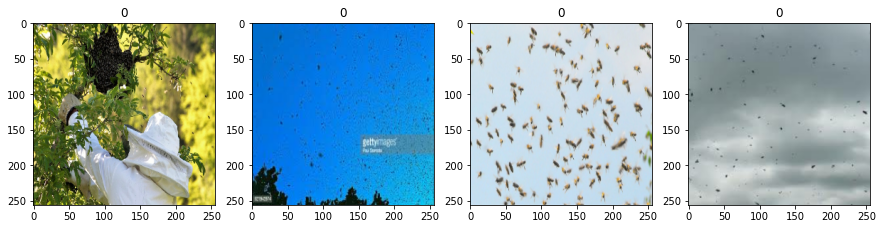

In [85]:
# Visualizing some of our images
fig, ax = plt.subplots(ncols=4, figsize=(15,7))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])


# Scaling Down Images

In [86]:
data = data.map(lambda x,y: (x/255, y))

In [87]:
batch = data.as_numpy_iterator().next()

# Splitting the data

In [88]:
# Setting the size of train, validation and test sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data)) 
test_size = int(0.1 * len(data)) 
print(train_size, val_size, test_size)



14 4 2


In [89]:
# Actually splitting the data
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

# Training the model

In [90]:
logs = "logs"

In [93]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Create a model
model1 = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPool2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Conv2D(16, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model1.compile(
    loss = "binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

callbacks = tf.keras.callbacks.TensorBoard(log_dir=logs)

# Fit the model
hist1 = model1.fit(train_data, validation_data=val_data, epochs=20, callbacks=[callbacks])



Epoch 1/20


2022-05-28 14:33:17.035979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 8.3245 - accuracy: 0.5000 - recall_3: 0.5446 - precision_3: 0.4545

2022-05-28 14:33:19.399456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 4s 195ms/step - loss: 8.3245 - accuracy: 0.5000 - recall_3: 0.5446 - precision_3: 0.4545 - val_loss: 0.6945 - val_accuracy: 0.4531 - val_recall_3: 1.0000 - val_precision_3: 0.4531
Epoch 2/20
14/14 [==============================] - 4s 199ms/step - loss: 0.6941 - accuracy: 0.4598 - recall_3: 0.9307 - precision_3: 0.4519 - val_loss: 0.6928 - val_accuracy: 0.6250 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 3/20
14/14 [==============================] - 3s 186ms/step - loss: 0.6927 - accuracy: 0.5357 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - val_loss: 0.6850 - val_accuracy: 0.7500 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 4/20
14/14 [==============================] - 3s 185ms/step - loss: 0.6900 - accuracy: 0.5759 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - val_loss: 0.6815 - val_accuracy: 0.6406 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 5/20
14/14 [=========================

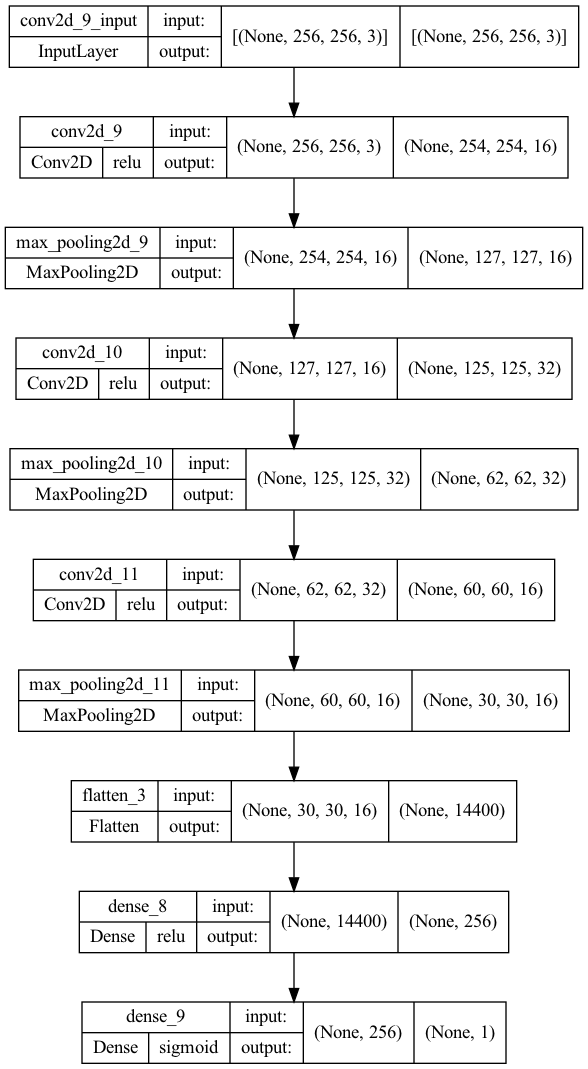

In [94]:
# Plotting the model's architecture
plot_model(model1,"models/model1.png", show_shapes=True, show_layer_activations=True)

In [95]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

In [96]:
# Evaluate the model
model1.evaluate(test_data)

2/2 [==============================] - 1s 56ms/step - loss: 0.6509 - accuracy: 0.7059 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00


[0.6509241461753845, 0.7058823704719543, 0.0, 0.0]

KeyError: 'precision_1'

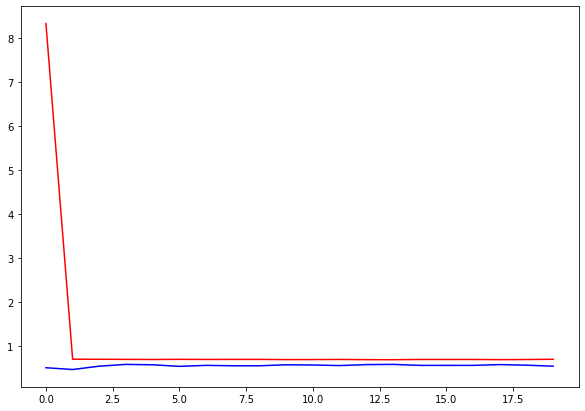

In [97]:
hist1_df = pd.DataFrame(hist1.history)
plt.figure(figsize=(10,7))
plt.plot(hist1_df["loss"],label="loss", color="red")
plt.plot(hist1_df["accuracy"], label="accuracy", c="blue")
plt.plot(hist1_df["precision_1"], label="precision", c="green")
plt.plot(hist1_df["recall_1"], label="recall", c="orange")
plt.legend();


In [99]:
hist1.history.keys()

dict_keys(['loss', 'accuracy', 'recall_3', 'precision_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3'])

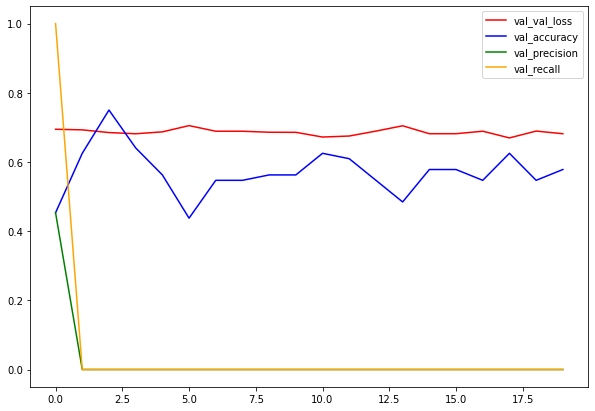

In [100]:
hist1_df = pd.DataFrame(hist1.history)
plt.figure(figsize=(10,7))
plt.plot(hist1_df["val_loss"],label="val_val_loss", color="red")
plt.plot(hist1_df["val_accuracy"], label="val_accuracy", c="blue")
plt.plot(hist1_df["val_precision_3"], label="val_precision", c="green")
plt.plot(hist1_df["val_recall_3"], label="val_recall", c="orange")
plt.legend();

# Creating model 2

In [102]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Create 2nd model
model2 = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPool2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Conv2D(16, (3,3), activation="relu"),
    MaxPool2D(2,2),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model2.compile(
    loss = "binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
)

# Add callbacks for the second model
callbacks2 = tf.keras.callbacks.TensorBoard(log_dir=logs)

# Fit the model
hist2 = model2.fit(train_data, validation_data=val_data, epochs=100, callbacks=[callbacks2])

Epoch 1/100


2022-05-28 14:38:30.519089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.2275 - accuracy: 0.5179 - recall_4: 0.4272 - precision_4: 0.4731

2022-05-28 14:38:32.799930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 4s 199ms/step - loss: 1.2275 - accuracy: 0.5179 - recall_4: 0.4272 - precision_4: 0.4731 - val_loss: 0.6212 - val_accuracy: 0.6094 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 3s 185ms/step - loss: 0.6321 - accuracy: 0.6429 - recall_4: 0.5294 - precision_4: 0.6279 - val_loss: 0.6265 - val_accuracy: 0.6406 - val_recall_4: 1.0000 - val_precision_4: 0.5577
Epoch 3/100
14/14 [==============================] - 3s 175ms/step - loss: 0.5549 - accuracy: 0.7054 - recall_4: 0.8137 - precision_4: 0.6385 - val_loss: 0.5114 - val_accuracy: 0.6562 - val_recall_4: 0.7200 - val_precision_4: 0.5455
Epoch 4/100
14/14 [==============================] - 3s 177ms/step - loss: 0.4854 - accuracy: 0.7813 - recall_4: 0.7745 - precision_4: 0.7524 - val_loss: 0.4588 - val_accuracy: 0.8125 - val_recall_4: 0.6538 - val_precision_4: 0.8500
Epoch 5/100
14/14 [==============================] - 3s 173ms/step - los

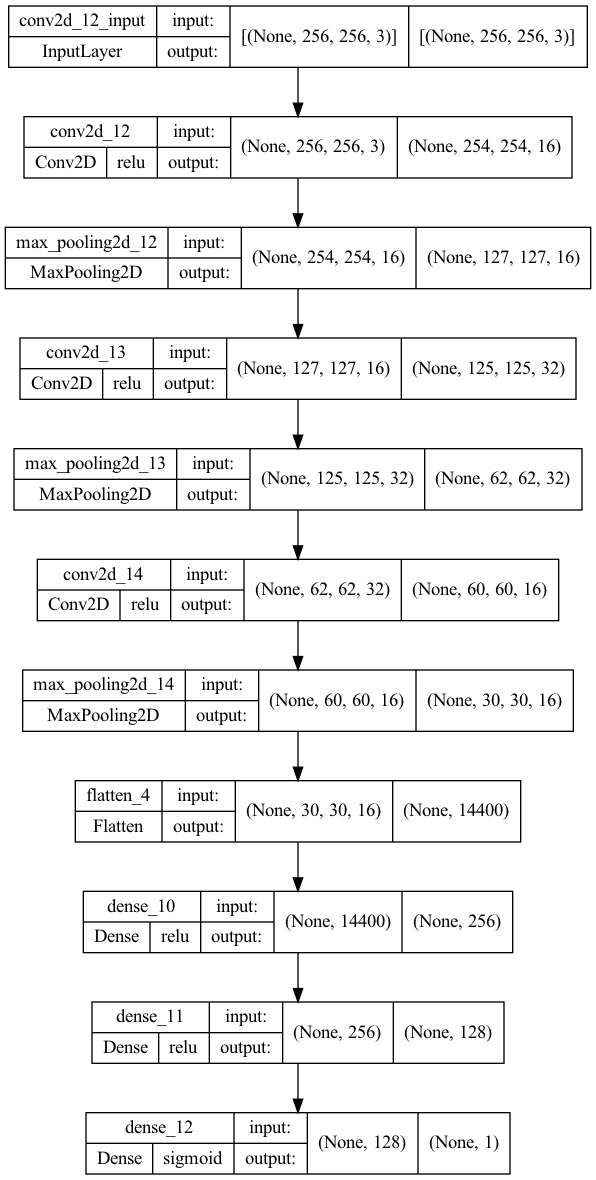

In [103]:
plot_model(model2, "models/model2.png",show_layer_activations=True, show_shapes=True)

In [104]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

In [105]:
# Evaluate the second model
model2.evaluate(test_data)


2/2 [==============================] - 2s 79ms/step - loss: 6.3430e-06 - accuracy: 1.0000 - recall_4: 1.0000 - precision_4: 1.0000


[6.34303569313488e-06, 1.0, 1.0, 1.0]

KeyError: 'precision_2'

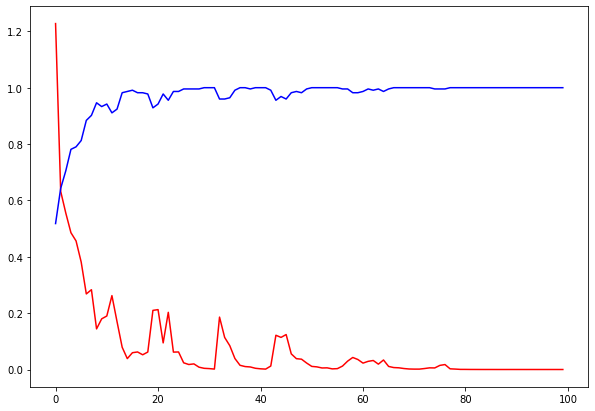

In [106]:
hist2_df = pd.DataFrame(hist2.history)
plt.figure(figsize=(10,7))
plt.plot(hist2_df["loss"],label="loss", color="red")
plt.plot(hist2_df["accuracy"], label="accuracy", c="blue")
plt.plot(hist2_df["precision_2"], label="precision", c="green")
plt.plot(hist2_df["recall_2"], label="recall", c="orange")
plt.legend();


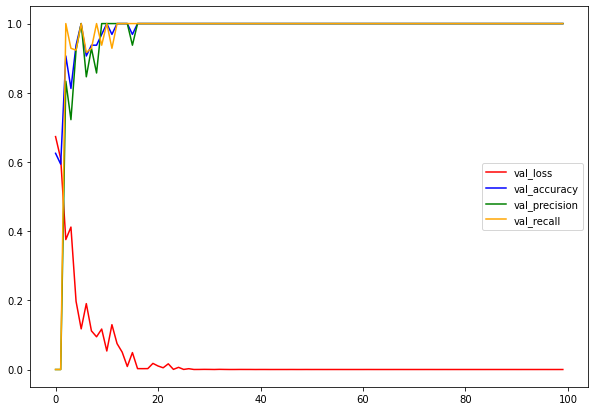

In [78]:
# Plot validation loss and accuracy
plt.figure(figsize=(10,7))
plt.plot(hist2_df["val_loss"],label="val_loss", color="red")
plt.plot(hist2_df["val_accuracy"], label="val_accuracy", c="blue")
plt.plot(hist2_df["val_precision_2"], label="val_precision", c="green")
plt.plot(hist2_df["val_recall_2"], label="val_recall", c="orange")
plt.legend();

In [107]:
# Predicting on random bee swarming images from the internet
def predict_bee_swarming(model, img_path):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Resizing the image
    resized = tf.image.resize(img, (256,256))

    # Actually classifying the image
    yhat = model.predict(tf.expand_dims(resized/255, axis=0))
    print(yhat)
    if yhat < 0.5:
        print("This image is bee swarming")
    else:
        print("This image is not bee swarming")

[[0.992669]]
This image is not bee swarming


2022-05-28 14:44:57.732656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


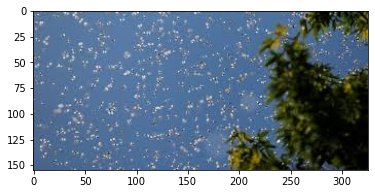

In [108]:
predict_bee_swarming(model2, "images_for_test/images-3.jpeg")

# Creating model 3

In [25]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Create a model
model3 = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPool2D(2,2),
    Dropout(0.2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Dropout(0.2),

    Conv2D(16, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model3.compile(
    loss = "binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
)

# Add callbacks for the third model
callbacks3 = tf.keras.callbacks.TensorBoard(log_dir=logs)

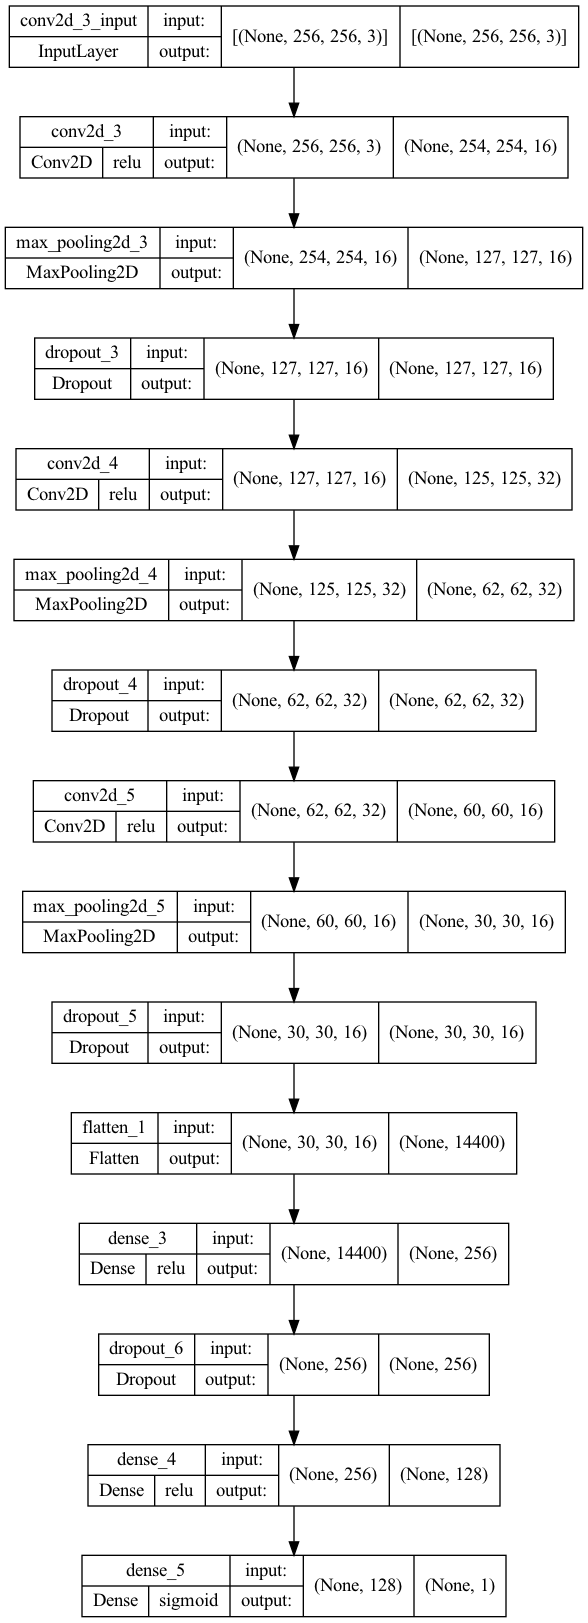

In [26]:
plot_model(model3, "model3.png", show_layer_activations=True, show_shapes=True)

In [27]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 32)       

In [28]:
# Fit the model
hist3 = model3.fit(train_data, validation_data=val_data, epochs=100, callbacks=[callbacks3])

Epoch 1/100


2022-05-28 13:50:39.096256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.4777 - recall_1: 0.6759 - precision_1: 0.4710

2022-05-28 13:50:42.006126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 5s 244ms/step - loss: 1.0684 - accuracy: 0.4777 - recall_1: 0.6759 - precision_1: 0.4710 - val_loss: 0.6925 - val_accuracy: 0.6875 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 4s 209ms/step - loss: 0.6727 - accuracy: 0.6116 - recall_1: 0.4554 - precision_1: 0.5897 - val_loss: 0.6838 - val_accuracy: 0.5469 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 3s 201ms/step - loss: 0.6961 - accuracy: 0.5402 - recall_1: 0.1134 - precision_1: 0.3929 - val_loss: 0.6905 - val_accuracy: 0.6094 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 3s 185ms/step - loss: 0.6823 - accuracy: 0.5670 - recall_1: 0.0206 - precision_1: 0.5000 - val_loss: 0.6792 - val_accuracy: 0.6719 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 5/100
14/14 [=============================

In [29]:
# Evaluating the model
model3.evaluate(test_data)

2/2 [==============================] - 1s 124ms/step - loss: 0.0038 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000


[0.0037590384017676115, 1.0, 1.0, 1.0]

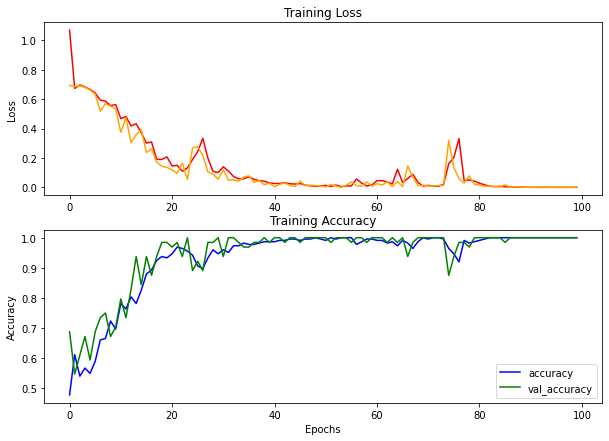

In [33]:
# Visualizing the model's training
hist3_df = pd.DataFrame(hist3.history)

# Creating 2 horizontal subplots, and add padding to the top and bottom
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
# Visualizing the training accuracy
ax2.plot(hist3_df["accuracy"], label="accuracy", color="blue")
ax2.plot(hist3_df["val_accuracy"], label="val_accuracy", color="green")
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
# Visualizing the training loss
ax1.plot(hist3_df["loss"], label="loss", color="red")
ax1.plot(hist3_df["val_loss"], label="val_loss", color="orange")
ax1.set_title("Training Loss")
ax1.set_ylabel("Loss")
plt.legend();


In [36]:
hist3.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'precision_1', 'val_loss', 'val_accuracy', 'val_recall_1', 'val_precision_1'])

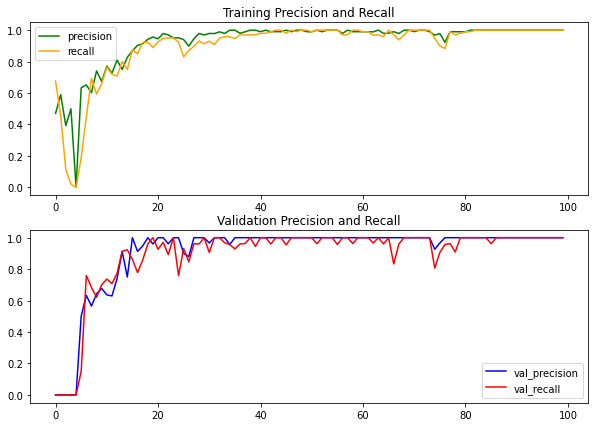

In [40]:
# Visualizing the training precision and recall
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
ax1.plot(hist3_df["precision_1"], label="precision", c="green")
ax1.plot(hist3_df["recall_1"], label="recall", c="orange")
ax1.set_title("Training Precision and Recall")
ax2.plot(hist3_df["val_precision_1"], label="val_precision", c="blue")
ax2.plot(hist3_df["val_recall_1"], label="val_recall", c="red")
ax2.set_title("Validation Precision and Recall")
ax1.legend();
ax2.legend();


[[0.0454095]]
This image is bee swarming


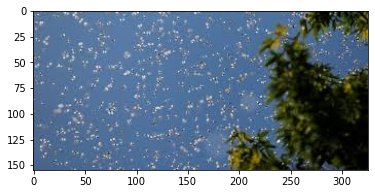

In [79]:
predict_bee_swarming(model3, "images_for_test/images-3.jpeg")

In [80]:
# Saving the model
model3.save("model3.h5")

# Comparing the 2 last models' training

In [116]:
hist2.history.keys()

dict_keys(['loss', 'accuracy', 'recall_4', 'precision_4', 'val_loss', 'val_accuracy', 'val_recall_4', 'val_precision_4'])

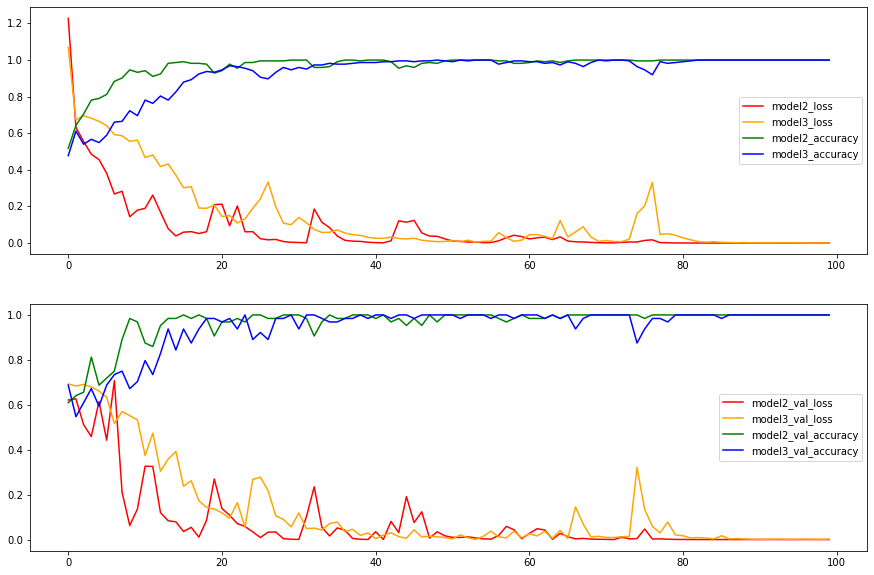

In [124]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
ax1.plot(hist2_df["loss"], label="model2_loss", color="red")
ax1.plot(hist3_df["loss"], label="model3_loss", color="orange")
ax1.plot(hist2_df["accuracy"], label="model2_accuracy", color="green")
ax1.plot(hist3_df["accuracy"], label="model3_accuracy", color="blue")
ax1.legend();
ax2.plot(hist2_df["val_loss"], label="model2_val_loss", color="red")
ax2.plot(hist3_df["val_loss"], label="model3_val_loss", color="orange")
ax2.plot(hist2_df["val_accuracy"], label="model2_val_accuracy", color="green")
ax2.plot(hist3_df["val_accuracy"], label="model3_val_accuracy", color="blue")
ax2.legend();



In [152]:
hist2.history.keys()

dict_keys(['loss', 'accuracy', 'recall_4', 'precision_4', 'val_loss', 'val_accuracy', 'val_recall_4', 'val_precision_4'])

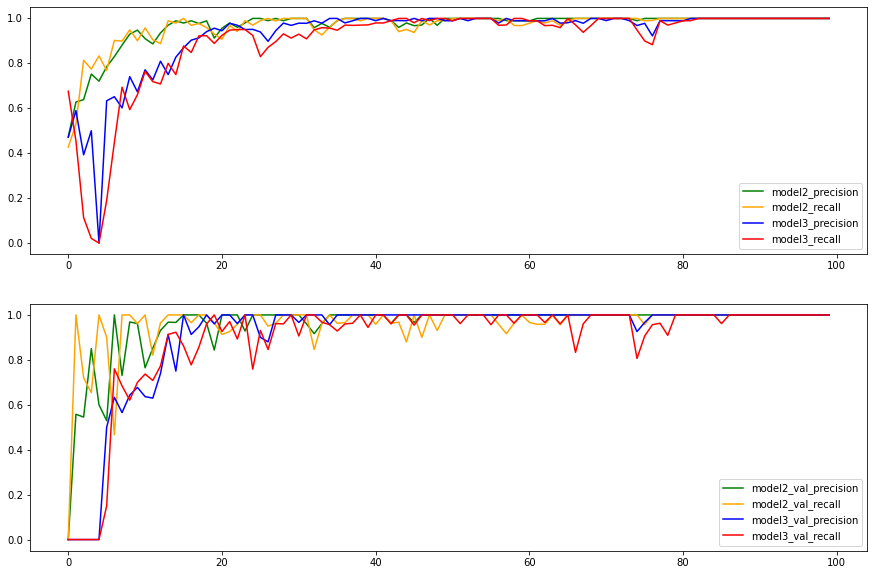

In [153]:
# Visualizing and comparing the models' training precision and recall
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
ax1.plot(hist2_df["precision_4"], label="model2_precision", c="green")
ax1.plot(hist2_df["recall_4"], label="model2_recall", c="orange")
ax1.plot(hist3_df["precision_1"], label="model3_precision", c="blue")
ax1.plot(hist3_df["recall_1"], label="model3_recall", c="red")
ax1.legend();
ax2.plot(hist2_df["val_precision_4"], label="model2_val_precision", c="green")
ax2.plot(hist2_df["val_recall_4"], label="model2_val_recall", c="orange")
ax2.plot(hist3_df["val_precision_1"], label="model3_val_precision", c="blue")
ax2.plot(hist3_df["val_recall_1"], label="model3_val_recall", c="red")
ax2.legend();

In [4]:
# Predicting bee swarming using my laptop's webcam

def predict_bee_swarming_from_webcam(model):
    # Initialize webcam
    cam = cv2.VideoCapture(0)

    s, img = cam.read()
    cv2.imwrite("image_prediction.jpeg", img)

    # Releasing the camera, so that we don't capture video all the time
    cam.release()
    cv2.destroyAllWindows()

    # Convert the image into a numpy array
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)
    print(prediction)

    # Convert the prediction into a string and display it
    if prediction[0][0] > 0.5:
        prediction = "bees are swarming"
    else:
        prediction = "bees are not swarming"
    print(prediction)



In [7]:
# load the model
model = tf.keras.models.load_model("models/model3.h5")

# Initialize webcam
cam = cv2.VideoCapture(0)

s, img = cam.read()
cv2.imwrite("image_prediction.jpeg", img)

# Releasing the camera, so that we don't capture video all the time
cam.release()
cv2.destroyAllWindows()

# Convert the image into a numpy array
img = cv2.resize(img, (256, 256))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Predict
prediction = model.predict(img)
print(prediction)

# Convert the prediction into a string and display it
if prediction[0][0] > 0.5:
    prediction = "bees are swarming"
else:
    prediction = "bees are not swarming"
print(prediction)



[[0.01913062]]
bees are not swarming


2022-05-28 15:35:20.510827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
